# Jupyter Notebook to train a model

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tf_explain.callbacks.grad_cam import GradCAMCallback

# use random seed to reproduce results
np.random.seed(42)
tf.random.set_seed(42)

import matplotlib as mpl
import matplotlib.pyplot as plt
import os

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn_metrics"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

2021-12-22 16:58:29.962657: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


### lists possible devices (CPU, GPU), used to check if GPU is recognized/exists

In [2]:
tf.config.get_visible_devices()

2021-12-22 16:58:31.737660: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

2021-12-22 16:58:31.738493: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-12-22 16:58:31.795048: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-22 16:58:31.795189: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1080 computeCapability: 6.1
coreClock: 1.8225GHz coreCount: 20 deviceMemorySize: 7.93GiB deviceMemoryBandwidth: 298.32GiB/s
2021-12-22 16:58:31.795206: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-12-22 16:58:31.796433: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-12-22 16:58:31.796477: I tensorflow/stream_executor/pl

## Methods

### used to save a trained model as a json file and its weights as a h5 file

In [3]:
def save_model(model, model_name, path):
    my_model = model.to_json()
    with open(f'./{path}/{model_name}.json', "w") as file:
        file.write(my_model)
    # serialize weights to HDF5
    model.save_weights(f'./{path}/{model_name}_weights.h5')

### used to build the base model using predefined architectures
currently: vgg16, xception, resnet

In [4]:
def build_base_model(architecture, weights):
    input = tf.keras.Input(shape=(224, 224, 3))
    if architecture == 'vgg16':
        return tf.keras.applications.vgg16.VGG16(weights=weights, include_top=False, input_tensor=input)
    if architecture == 'xception':
        return tf.keras.applications.xception.Xception(weights=weights, include_top=False, input_tensor=input)
    if architecture == 'resnet':
        return tf.keras.applications.resnet.ResNet50(weights=weights, include_top=False, input_tensor=input)

### gets base model as input and builds a new top layer and returns the model with custom top layers

In [5]:
def build_model(base_model):
    flat = keras.layers.Flatten(name='flatten')(base_model.output)
    dense_1 = keras.layers.Dense(1400)(flat)
    dropout = keras.layers.Dropout(0.25)(dense_1)
    batch = keras.layers.BatchNormalization()(dropout)
    output = keras.layers.Dense(1, activation='sigmoid')(batch)
    return tf.keras.Model(base_model.input, output)

### gets a model as input and returns a model compiled with the adam optimizer

In [6]:
def compile_model(model, alpha, beta1, beta2, metrics):
    optimizer = keras.optimizers.Adam(learning_rate=alpha, beta_1=beta1, beta_2=beta2)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=metrics)
    return model

### gets a model as input and trains it on the data-set with the defined callbacks and epochs

In [7]:
def train_model(model, train_set, validation_set, epochs, callback):
    return model.fit(train_set,
                     validation_data=validation_set,
                     epochs=epochs,
                     callbacks=callback)

### gets a model as input and changes its layers trainable attribute

In [8]:
def set_layers_trainable(trainable, input_model):
    for layer in input_model.layers:
        layer.trainable = trainable

## Data preprocessing

preprocessing of the images applied when loading image data set from disk with tensorflows flow_from_directory


In [9]:
image_gen = keras.preprocessing.image.ImageDataGenerator(rotation_range=20,  # rotate the image 20 degrees
                                                         width_shift_range=0.2,
                                                         height_shift_range=0.2,
                                                         rescale=1 / 255,  # Rescale the image by normalzing it.
                                                         shear_range=0.15,
                                                         # Shear means cutting away part of the image (max 20%)
                                                         zoom_range=0.15,  # Zoom in by 15% max
                                                         horizontal_flip=True,  # Allow horizontal flipping
                                                         fill_mode='nearest'
                                                         # Fill in missing pixels with the nearest filled value
                                                         )
t_image_gen = keras.preprocessing.image.ImageDataGenerator()

path to the data set

In [24]:
train_data_path = './data/data_full/train'  #local notebook
validation_data_path = './data/data_full/val'  #local notebook
test_data_path = './data/data_full/test'  #local notebook
# train_data_path = './data/data_heavily_reduced/data_balanced/train'  #local notebook
# validation_data_path = './data/data_heavily_reduced/data_balanced/val'  #local notebook
# test_data_path = './data/data_heavily_reduced/data_balanced/test'  #local notebook

generate training set by loading the images from their directories with flow_from_directory
important: the folder structure has to match! i.e {train} -> {ok,def}
at the "same time" the data augmentation is applied on the images through the ImageDataGenerator

In [25]:
# set for xception
# batch_size = 24
train_image_gen = image_gen.flow_from_directory(train_data_path,
                                                target_size=(224, 224),
                                                class_mode='binary')

Found 7999 images belonging to 2 classes.


In [26]:
valid_image_gen = t_image_gen.flow_from_directory(validation_data_path,
                                                target_size=(224, 224),
                                                class_mode='binary')

Found 999 images belonging to 2 classes.


In [27]:
test_image_gen = t_image_gen.flow_from_directory(test_data_path,
                                               target_size=(224, 224),
                                               class_mode='binary')

Found 1001 images belonging to 2 classes.


# Training of the model

In [36]:
vgg16 = build_base_model('vgg16', 'imagenet')
vgg16_model = build_model(vgg16)
vgg16_model = compile_model(vgg16_model, 0.0001, 0.9, 0.999, ['accuracy', 'Recall', 'Precision', 'AUC'])
set_layers_trainable(False, vgg16)
history = train_model(vgg16_model, train_image_gen, valid_image_gen, 5, [])
set_layers_trainable(True, vgg16)
save_model(vgg16_model, 'vgg16_first_train_step', 'saved_models/first_train_step/default_params/reduced_data')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs", histogram_freq=5, write_graph=True,
                                                      write_images=True)
custom_early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
vgg16_model = compile_model(vgg16_model, 0.0001, 0.9, 0.999, ['accuracy', 'Recall', 'Precision', 'AUC'])
history = train_model(vgg16_model, train_image_gen, valid_image_gen, 100,
                      [custom_early_stopping, tensorboard_callback])
loss, accuracy, recall, precision, auc = vgg16_model.evaluate(test_image_gen)
# F1 score
f1 = 2 * ((precision * recall) / (precision + recall))

print(f"loss: {loss}, \n"
      f"accuracy: {accuracy}, \n"
      f"recall: {recall}, \n"
      f"precision: {precision}, \n"
      f"auc: {auc}, \n"
      f"F1: {f1}")
save_model(vgg16_model, 'vgg16', 'saved_models/second_train_step/default_params/reduced_data')
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
save_fig('vgg16_loss', tight_layout=False)
plt.show()
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
save_fig('vgg16_accuracy', tight_layout=False)
plt.show()
plt.plot(history.epoch, metrics['recall'], metrics['val_recall'])
plt.legend(['recall', 'val_recall'])
save_fig('vgg16_recall', tight_layout=False)
plt.show()
plt.plot(history.epoch, metrics['precision'], metrics['val_precision'])
plt.legend(['precision', 'val_precision'])
save_fig('vgg16_precision', tight_layout=False)
plt.show()
plt.plot(history.epoch, metrics['auc'], metrics['val_auc'])
plt.legend(['auc', 'val_auc'])
save_fig('vgg16_auc', tight_layout=False)
plt.show()

Epoch 1/5


2021-12-22 17:08:52.112276: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


152/250 [=================>............] - ETA: 34s - loss: 0.3998 - accuracy: 0.8398 - recall: 0.8567 - precision: 0.8278 - auc: 0.9167

2021-12-22 17:09:58.317192: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.01GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


250/250 [==============================] - 122s 455ms/step - loss: 0.3432 - accuracy: 0.8640 - recall: 0.8814 - precision: 0.8514 - auc: 0.9354 - val_loss: 0.1187 - val_accuracy: 0.9439 - val_recall: 0.9479 - val_precision: 0.9404 - val_auc: 0.9914
Epoch 2/5
250/250 [==============================] - 97s 388ms/step - loss: 0.1284 - accuracy: 0.9500 - recall: 0.9577 - precision: 0.9432 - auc: 0.9888 - val_loss: 1.6419 - val_accuracy: 0.5786 - val_recall: 0.1583 - val_precision: 0.9875 - val_auc: 0.8814
Epoch 3/5
250/250 [==============================] - 96s 385ms/step - loss: 0.0905 - accuracy: 0.9645 - recall: 0.9715 - precision: 0.9585 - auc: 0.9942 - val_loss: 0.1039 - val_accuracy: 0.9520 - val_recall: 0.9158 - val_precision: 0.9870 - val_auc: 0.9971
Epoch 4/5
250/250 [==============================] - 96s 385ms/step - loss: 0.0712 - accuracy: 0.9735 - recall: 0.9786 - precision: 0.9682 - auc: 0.9968 - val_loss: 0.0582 - val_accuracy: 0.9810 - val_recall: 0.9800 - val_precision: 0.

2021-12-22 17:17:13.533318: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-12-22 17:17:13.533339: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-12-22 17:17:13.533372: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1365] Profiler found 1 GPUs
2021-12-22 17:17:13.533889: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcupti.so.10.1
2021-12-22 17:17:13.634368: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2021-12-22 17:17:13.634813: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


Epoch 1/100
  1/250 [..............................] - ETA: 6:56 - loss: 0.0112 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - auc: 1.0000

2021-12-22 17:17:15.673854: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-12-22 17:17:15.673872: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-12-22 17:17:15.674339: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES


  2/250 [..............................] - ETA: 1:47 - loss: 0.0640 - accuracy: 0.9922 - recall: 1.0000 - precision: 0.9833 - auc: 0.9916

2021-12-22 17:17:16.037439: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-12-22 17:17:16.040195: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-12-22 17:17:16.041348: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-12-22 17:17:16.047954: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./logs/train/plugins/profile/2021_12_22_17_17_16
2021-12-22 17:17:16.048712: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_12_22_17_17_16/pop-os.trace.json.gz
2021-12-22 17:17:16.063858: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./logs/train/plugins/profile/2021_12_22_17_17_16
2021-12-22 17:17:16.066571: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped

250/250 [==============================] - 98s 389ms/step - loss: 0.0899 - accuracy: 0.9698 - recall: 0.9750 - precision: 0.9655 - auc: 0.9937 - val_loss: 0.0727 - val_accuracy: 0.9680 - val_recall: 0.9399 - val_precision: 0.9958 - val_auc: 0.9991
Epoch 2/100
250/250 [==============================] - 96s 385ms/step - loss: 0.0541 - accuracy: 0.9794 - recall: 0.9802 - precision: 0.9789 - auc: 0.9977 - val_loss: 0.0216 - val_accuracy: 0.9930 - val_recall: 0.9960 - val_precision: 0.9900 - val_auc: 0.9997
Epoch 3/100
250/250 [==============================] - 97s 388ms/step - loss: 0.0523 - accuracy: 0.9838 - recall: 0.9868 - precision: 0.9815 - auc: 0.9974 - val_loss: 0.0428 - val_accuracy: 0.9860 - val_recall: 0.9980 - val_precision: 0.9746 - val_auc: 0.9994
Epoch 4/100
 53/250 [=====>........................] - ETA: 1:11 - loss: 0.0522 - accuracy: 0.9845 - recall: 0.9812 - precision: 0.9879 - auc: 0.9972

KeyboardInterrupt: 

Epoch 1/5


2021-12-22 02:00:57.623813: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-12-22 02:00:57.903357: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-12-22 02:00:58.075041: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-12-22 02:00:58.284810: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Alloc

  37/1509 [..............................] - ETA: 7:45 - loss: 1.4441 - accuracy: 0.6622 - recall: 0.8035 - precision: 0.3006 - auc: 0.8027

2021-12-22 02:01:26.039932: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.29GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-12-22 02:01:26.325847: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.33GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-12-22 02:01:26.498202: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


1509/1509 [==============================] - 568s 363ms/step - loss: 0.2807 - accuracy: 0.9365 - recall: 0.9022 - precision: 0.7842 - auc: 0.9671 - val_loss: 3.0683 - val_accuracy: 0.4005 - val_recall: 0.8839 - val_precision: 0.2014 - val_auc: 0.6822
Epoch 2/5
1509/1509 [==============================] - 523s 347ms/step - loss: 0.0492 - accuracy: 0.9861 - recall: 0.9621 - precision: 0.9557 - auc: 0.9971 - val_loss: 0.0095 - val_accuracy: 0.9970 - val_recall: 0.9930 - val_precision: 0.9890 - val_auc: 1.0000
Epoch 3/5
1509/1509 [==============================] - 523s 347ms/step - loss: 0.0235 - accuracy: 0.9929 - recall: 0.9801 - precision: 0.9771 - auc: 0.9988 - val_loss: 0.0077 - val_accuracy: 0.9978 - val_recall: 0.9960 - val_precision: 0.9910 - val_auc: 0.9999
Epoch 4/5
1509/1509 [==============================] - 523s 347ms/step - loss: 0.0172 - accuracy: 0.9945 - recall: 0.9821 - precision: 0.9844 - auc: 0.9993 - val_loss: 0.0327 - val_accuracy: 0.9881 - val_recall: 0.9279 - val_pr

2021-12-22 02:45:08.904824: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-12-22 02:45:08.904848: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-12-22 02:45:08.904932: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2021-12-22 02:45:08.904946: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


Epoch 1/100
   1/1509 [..............................] - ETA: 1:43:25 - loss: 5.9768e-04 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - auc: 1.0000

2021-12-22 02:45:13.429021: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-12-22 02:45:13.429046: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-12-22 02:45:13.429117: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED


   2/1509 [..............................] - ETA: 10:34 - loss: 0.0012 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - auc: 1.0000      

2021-12-22 02:45:14.363460: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-12-22 02:45:14.378568: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-12-22 02:45:14.383887: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-12-22 02:45:14.396358: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./logs/train/plugins/profile/2021_12_22_02_45_14
2021-12-22 02:45:14.397907: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_12_22_02_45_14/pop-os.trace.json.gz
2021-12-22 02:45:14.435757: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./logs/train/plugins/profile/2021_12_22_02_45_14
2021-12-22 02:45:14.442487: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped

1509/1509 [==============================] - 528s 348ms/step - loss: 0.0124 - accuracy: 0.9958 - recall: 0.9863 - precision: 0.9887 - auc: 0.9994 - val_loss: 0.0071 - val_accuracy: 0.9980 - val_recall: 0.9900 - val_precision: 0.9980 - val_auc: 1.0000
Epoch 2/100
1509/1509 [==============================] - 523s 346ms/step - loss: 0.0113 - accuracy: 0.9965 - recall: 0.9885 - precision: 0.9902 - auc: 0.9993 - val_loss: 0.0117 - val_accuracy: 0.9964 - val_recall: 0.9830 - val_precision: 0.9949 - val_auc: 0.9998
Epoch 3/100
1509/1509 [==============================] - 523s 346ms/step - loss: 0.0082 - accuracy: 0.9974 - recall: 0.9912 - precision: 0.9929 - auc: 0.9997 - val_loss: 0.1231 - val_accuracy: 0.9576 - val_recall: 0.7618 - val_precision: 0.9769 - val_auc: 0.9853
Epoch 4/100
1509/1509 [==============================] - 523s 346ms/step - loss: 0.0059 - accuracy: 0.9978 - recall: 0.9927 - precision: 0.9941 - auc: 0.9999 - val_loss: 0.0055 - val_accuracy: 0.9983 - val_recall: 0.9970 - 

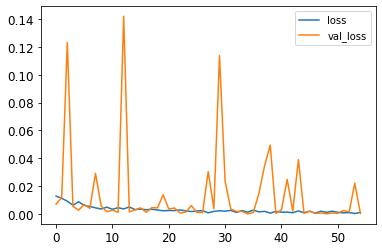

Saving figure resNet_accuracy


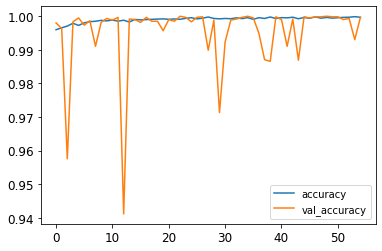

Saving figure resNet_recall


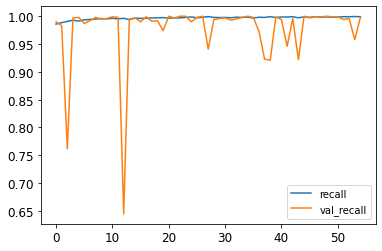

Saving figure resNet_precision


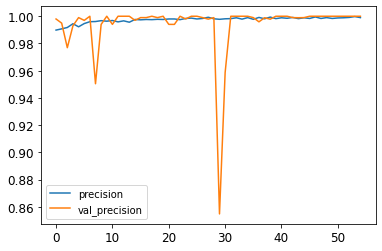

Saving figure resNet_auc


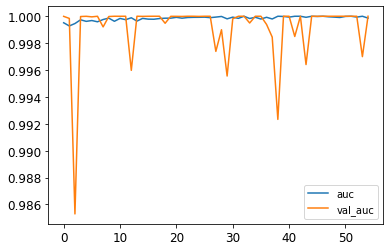

In [15]:
resnet = build_base_model('resnet', 'imagenet')
resnet_model = build_model(resnet)
resnet_model = compile_model(resnet_model, 0.0001, 0.9, 0.999, ['accuracy', 'Recall', 'Precision', 'AUC'])
set_layers_trainable(False, resnet)
res_history = train_model(resnet_model, train_image_gen, valid_image_gen, 5, [])
set_layers_trainable(True, resnet)
save_model(resnet_model, 'resnet_first_train_step', 'saved_models/first_train_step/default_params/reduced_data')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs", histogram_freq=5, write_graph=True,
                                                      write_images=True)
custom_early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
resnet_model = compile_model(resnet_model, 0.0001, 0.9, 0.999, ['accuracy', 'Recall', 'Precision', 'AUC'])
res_history = train_model(resnet_model, train_image_gen, valid_image_gen, 100,
                          [custom_early_stopping, tensorboard_callback])
loss, accuracy, recall, precision, auc = resnet_model.evaluate(test_image_gen)
# F1 score
f1 = 2 * ((precision * recall) / (precision + recall))

print(f"loss: {loss}, \n"
      f"accuracy: {accuracy}, \n"
      f"recall: {recall}, \n"
      f"precision: {precision}, \n"
      f"auc: {auc}, \n"
      f"F1: {f1}")

save_model(resnet_model, 'resnet', 'saved_models/second_train_step/default_params/reduced_data')
metrics = res_history.history
plt.plot(res_history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
save_fig('restNet_loss', tight_layout=False)
plt.show()
plt.plot(res_history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
save_fig('resNet_accuracy', tight_layout=False)
plt.show()
plt.plot(res_history.epoch, metrics['recall'], metrics['val_recall'])
plt.legend(['recall', 'val_recall'])
save_fig('resNet_recall', tight_layout=False)
plt.show()
plt.plot(res_history.epoch, metrics['precision'], metrics['val_precision'])
plt.legend(['precision', 'val_precision'])
save_fig('resNet_precision', tight_layout=False)
plt.show()
plt.plot(res_history.epoch, metrics['auc'], metrics['val_auc'])
plt.legend(['auc', 'val_auc'])
save_fig('resNet_auc', tight_layout=False)
plt.show()

In [14]:
xception = build_base_model('xception', 'imagenet')
xception_model = build_model(xception)
xception_model = compile_model(xception_model, 0.0001, 0.9, 0.999, ['accuracy', 'Recall', 'Precision', 'AUC'])
set_layers_trainable(False, xception)
xc_history = train_model(xception_model, train_image_gen, valid_image_gen, 5, [])
set_layers_trainable(True, xception)
save_model(xception_model, 'xception_first_train_step', 'saved_models/first_train_step/default_params/full_data')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs", histogram_freq=5, write_graph=True,
                                                      write_images=True)
custom_early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
xception_model = compile_model(xception_model, 0.0001, 0.9, 0.999, ['accuracy', 'Recall', 'Precision', 'AUC'])
xc_history = train_model(xception_model, train_image_gen, valid_image_gen, 100,
                         [custom_early_stopping, tensorboard_callback])
loss, accuracy, recall, precision, auc = xception_model.evaluate(test_image_gen)
# F1 score
f1 = 2 * ((precision * recall) / (precision + recall))

print(f"loss: {loss}, \n"
      f"accuracy: {accuracy}, \n"
      f"recall: {recall}, \n"
      f"precision: {precision}, \n"
      f"auc: {auc}, \n"
      f"F1: {f1}")
save_model(xception_model, 'xception', 'saved_models/second_train_step/default_params/full_data')
tf.config.get_visible_devices()
metrics = xc_history.history
plt.plot(xc_history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
save_fig('xception_loss', tight_layout=False)
plt.show()
plt.plot(xc_history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
save_fig('xception_accuracy', tight_layout=False)
plt.show()
plt.plot(xc_history.epoch, metrics['recall'], metrics['val_recall'])
plt.legend(['recall', 'val_recall'])
save_fig('xception_recall', tight_layout=False)
plt.show()
plt.plot(xc_history.epoch, metrics['precision'], metrics['val_precision'])
plt.legend(['precision', 'val_precision'])
save_fig('xception_precision', tight_layout=False)
plt.show()
plt.plot(xc_history.epoch, metrics['auc'], metrics['val_auc'])
plt.legend(['auc', 'val_auc'])
save_fig('xception_auc', tight_layout=False)
plt.show()

2021-12-22 11:44:01.604895: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-22 11:44:01.605314: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-22 11:44:01.605462: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1080 computeCapability: 6.1
coreClock: 1.8225GHz coreCount: 20 deviceMemorySize: 7.93GiB deviceMemoryBandwidth: 298.32GiB/s
2021-12-22 11:44:01.605495: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library li

Epoch 1/5


2021-12-22 11:44:07.169663: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-12-22 11:44:07.469811: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2021-12-22 11:44:08.351047: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2021-12-22 11:44:08.374505: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2021-12-22 11:44:11.835613: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.45GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-12-22 11:4

2012/2012 [==============================] - ETA: 0s - loss: 0.2550 - accuracy: 0.9230 - recall: 0.9084 - precision: 0.7455 - auc: 0.9647

2021-12-22 12:00:30.665999: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.42GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


2012/2012 [==============================] - 987s 484ms/step - loss: 0.2550 - accuracy: 0.9231 - recall: 0.9084 - precision: 0.7456 - auc: 0.9647 - val_loss: 0.0212 - val_accuracy: 0.9940 - val_recall: 0.9930 - val_precision: 0.9716 - val_auc: 0.9992
Epoch 2/5
2012/2012 [==============================] - 909s 452ms/step - loss: 0.0262 - accuracy: 0.9928 - recall: 0.9808 - precision: 0.9757 - auc: 0.9980 - val_loss: 0.0098 - val_accuracy: 0.9965 - val_recall: 0.9980 - val_precision: 0.9813 - val_auc: 1.0000
Epoch 3/5
2012/2012 [==============================] - 917s 456ms/step - loss: 0.0158 - accuracy: 0.9958 - recall: 0.9854 - precision: 0.9889 - auc: 0.9986 - val_loss: 0.0054 - val_accuracy: 0.9987 - val_recall: 0.9970 - val_precision: 0.9950 - val_auc: 0.9998
Epoch 4/5
2012/2012 [==============================] - 918s 456ms/step - loss: 0.0097 - accuracy: 0.9970 - recall: 0.9894 - precision: 0.9927 - auc: 0.9994 - val_loss: 0.0011 - val_accuracy: 0.9993 - val_recall: 0.9970 - val_pr

2021-12-22 13:01:49.721755: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-12-22 13:01:49.721776: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-12-22 13:01:49.722010: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1365] Profiler found 1 GPUs
2021-12-22 13:01:49.729746: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcupti.so.10.1
2021-12-22 13:01:49.830778: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2021-12-22 13:01:49.830932: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


Epoch 1/100
   1/2012 [..............................] - ETA: 2:01:32 - loss: 0.0036 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - auc: 1.0000

2021-12-22 13:01:53.796901: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-12-22 13:01:53.796921: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-12-22 13:01:53.797442: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES


   2/2012 [..............................] - ETA: 17:05 - loss: 0.0029 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - auc: 1.0000  

2021-12-22 13:01:54.224868: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-12-22 13:01:54.239459: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-12-22 13:01:54.242928: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-12-22 13:01:54.248729: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./logs/train/plugins/profile/2021_12_22_13_01_54
2021-12-22 13:01:54.250494: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_12_22_13_01_54/pop-os.trace.json.gz
2021-12-22 13:01:54.279881: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./logs/train/plugins/profile/2021_12_22_13_01_54
2021-12-22 13:01:54.284710: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped

2012/2012 [==============================] - 905s 448ms/step - loss: 0.0066 - accuracy: 0.9984 - recall: 0.9945 - precision: 0.9954 - auc: 0.9997 - val_loss: 0.0011 - val_accuracy: 0.9998 - val_recall: 0.9990 - val_precision: 1.0000 - val_auc: 1.0000
Epoch 2/100
2012/2012 [==============================] - 903s 449ms/step - loss: 0.0047 - accuracy: 0.9989 - recall: 0.9959 - precision: 0.9975 - auc: 0.9993 - val_loss: 0.0014 - val_accuracy: 0.9998 - val_recall: 1.0000 - val_precision: 0.9990 - val_auc: 1.0000
Epoch 3/100
2012/2012 [==============================] - 902s 448ms/step - loss: 0.0031 - accuracy: 0.9993 - recall: 0.9973 - precision: 0.9983 - auc: 0.9997 - val_loss: 8.7638e-04 - val_accuracy: 0.9997 - val_recall: 0.9990 - val_precision: 0.9990 - val_auc: 1.0000
Epoch 4/100
2012/2012 [==============================] - 899s 447ms/step - loss: 0.0040 - accuracy: 0.9990 - recall: 0.9957 - precision: 0.9983 - auc: 0.9996 - val_loss: 0.0018 - val_accuracy: 0.9995 - val_recall: 0.997

KeyboardInterrupt: 